In [14]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from model import init_weights
from model import Generator, Discriminator

In [15]:
data = "data/dataset/"

# random seed for reproducability
seed = 999
random.seed(seed)
torch.manual_seed(seed)


In [16]:
# hyperparameters
batch_size = 128
num_epochs = 40
image_size = 64
nc = 3 # num channels
nz = 100 # size of latent vector
ngf = 64 # num feature maps in generator
ndf = 64 # num feature maps in the discriminator
lr = 0.0002

In [17]:
dataset = torchvision.datasets.ImageFolder(
    root = data,
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle=True)
# device = torch.device("mps")
device = torch.device("cpu")

In [18]:
# setup model
generator = Generator(d_input=nz, d_features=ngf)
generator.apply(init_weights)
discriminator = Discriminator(num_channels=nc, d_features=ndf)
discriminator.apply(init_weights)

# loss function and optimizer
criterion = nn.BCELoss()
rand_noise = torch.randn(64, nz, 1, 1)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [19]:
# training loop
imgs_generated = []
gen_losses = []
disc_losses = []
iters = 0

print("Starting Training...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # each 'data' entry is 128 images * 3 channels * 128 * 128
        # train the discriminator: try to maximize log(D(x)) + log(1-D(G(z)))
        discriminator.zero_grad()
        # train with real images
        real_imgs = data[0]
        label = torch.full((real_imgs.size(0),), real_label, dtype=torch.float)
        output = discriminator(real_imgs).view(-1)
        lossd_real = criterion(output, label)
        lossd_real.backward()
        
        D_x = output.mean().item()
        
        # train with fake images
        noise = torch.randn(real_imgs.size(0), nz, 1, 1)
        fake_imgs = generator(noise)
        label.fill_(fake_label) # update the labels
        output = discriminator(fake_imgs.detach()).view(-1)
        lossd_fake = criterion(output, label)
        lossd_fake.backward()
        
        D_G_z1 = output.mean().item()
        
        lossd = lossd_fake + lossd_real
        optimizerD.step()
        
        
        # train the generator: try to maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake_imgs).view(-1)
        lossg = criterion(output, label)
        lossg.backward()
        D_G_z2 = lossg.mean().item()
        
        optimizerG.step()
        
        
        gen_losses.append(lossg.item())
        disc_losses.append(lossd.item())
        
        
        # check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            torch.save({
                'epoch': epoch,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': optimizerG.state_dict(),
            }, 'generator_2500.pth')

            # Save discriminator and optimizer
            torch.save({
                'epoch': epoch,
                'model_state_dict': discriminator.state_dict(),
                'optimizer_state_dict': optimizerD.state_dict(),
            }, 'discriminator_2500.pth')
            
            with torch.no_grad():
                fake = generator(noise).detach().cpu()
            imgs_generated.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, num_epochs, i, len(dataloader), lossd.item(), lossg.item(), D_x, D_G_z1, D_G_z2))
        

Starting Training...
[0/40][1/2]	Loss_D: 2.1662	Loss_G: 5.6376	D(x): 0.8943	D(G(z)): 0.8156 / 5.6376
[1/40][1/2]	Loss_D: 0.7145	Loss_G: 5.7286	D(x): 0.6766	D(G(z)): 0.1772 / 5.7286
[2/40][1/2]	Loss_D: 0.7798	Loss_G: 7.3616	D(x): 0.7674	D(G(z)): 0.3356 / 7.3616
[3/40][1/2]	Loss_D: 0.7660	Loss_G: 7.6593	D(x): 0.7290	D(G(z)): 0.2961 / 7.6593
[4/40][1/2]	Loss_D: 0.5318	Loss_G: 8.4506	D(x): 0.7975	D(G(z)): 0.2146 / 8.4506
[5/40][1/2]	Loss_D: 0.5301	Loss_G: 7.7611	D(x): 0.6996	D(G(z)): 0.1032 / 7.7611
[6/40][1/2]	Loss_D: 0.3756	Loss_G: 8.0400	D(x): 0.7490	D(G(z)): 0.0445 / 8.0400
[7/40][1/2]	Loss_D: 0.4243	Loss_G: 9.2029	D(x): 0.7327	D(G(z)): 0.0205 / 9.2029
[8/40][1/2]	Loss_D: 0.4719	Loss_G: 9.1887	D(x): 0.7040	D(G(z)): 0.0145 / 9.1887
[9/40][1/2]	Loss_D: 0.5037	Loss_G: 11.9289	D(x): 0.6817	D(G(z)): 0.0017 / 11.9289
[10/40][1/2]	Loss_D: 2.2135	Loss_G: 17.4349	D(x): 0.9285	D(G(z)): 0.8152 / 17.4349
[11/40][1/2]	Loss_D: 0.3203	Loss_G: 10.2364	D(x): 0.7493	D(G(z)): 0.0005 / 10.2364
[12/40][1/2

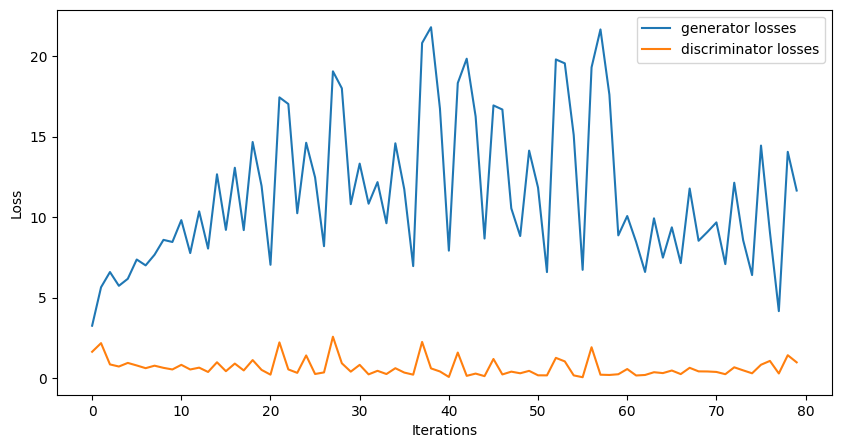

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label = "generator losses")
plt.plot(disc_losses, label = "discriminator losses")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


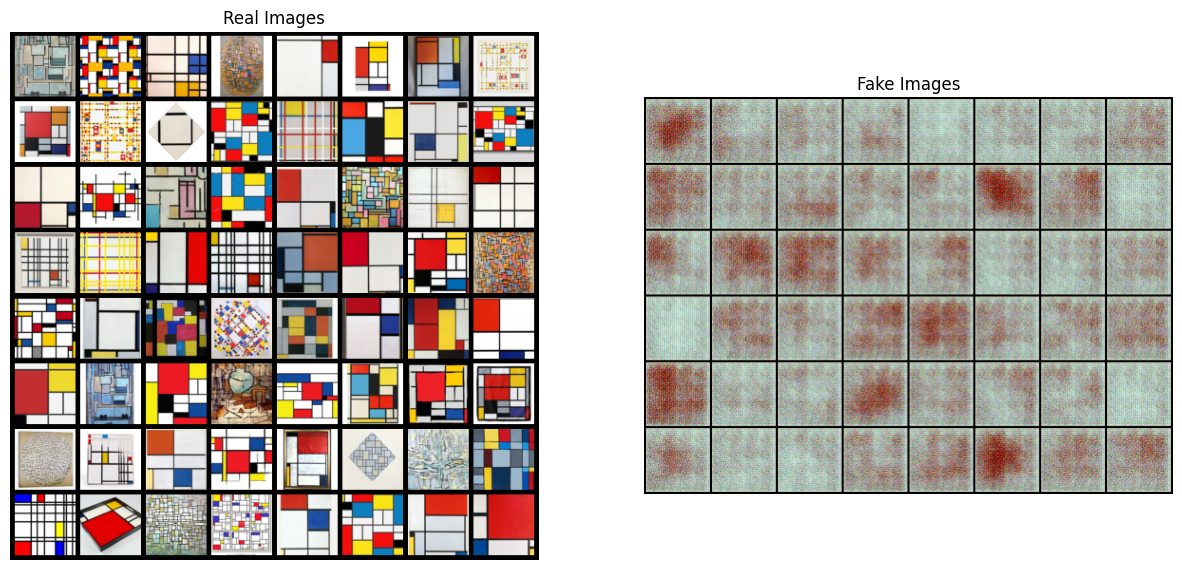

In [22]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(imgs_generated[-1],(1,2,0)))
plt.show()